#Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam, Adamax
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, BatchNormalization, LSTM, Discretization, Dropout,TimeDistributed, Flatten, GRU
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.callbacks import History
import seaborn as sns

#Carregando os dados

In [ ]:
carregando_clear = np.load('/content/drive/MyDrive/CLEAR(1).npy', mmap_mode='r')
dados_clear = carregando_clear[:5000000]

carregamento_lte1m = np.load('/content/drive/MyDrive/LTE_1M.npy', mmap_mode='r')
dados_lte1m = carregamento_lte1m[:5000000]

carregamento_wifi = np.load('/content/drive/MyDrive/WIFI.npy', mmap_mode='r')
dados_wifi = carregamento_wifi[:5000000]

In [ ]:
print(dados_clear.shape,dados_lte1m.shape,dados_wifi.shape)

(5000000, 1) (5000000, 1) (5000000, 1)


# Pre_processamento


In [ ]:
# adicionando pesos aos dados
dados_c = dados_clear*0.3
dados_l = dados_lte1m*0.9
dados_w =  dados_wifi*1.5

In [ ]:
#aplicando fourier e rotulando os dados
def fourier_processing (sinal_1, sinal_2,sinal_3):
    fft_1 = np.fft.fft(sinal_1)
    fft_2 = np.fft.fft(sinal_2)
    fft_3 = np.fft.fft(sinal_3)
    espectro_1 = np.abs(fft_1)
    espectro_2 = np.abs(fft_2)
    espectro_3 = np.abs(fft_3)
    frequencias_1 = np.fft.fftfreq(len(sinal_1))
    frequencias_2 = np.fft.fftfreq(len(sinal_2))
    frequencias_3 = np.fft.fftfreq(len(sinal_3))
    atributos1 = np.ones(len(sinal_1))
    atributos2 = np.zeros(len(sinal_2))
    atributos3 = np.ones(len(sinal_3))+1
    dados1 = np.column_stack((espectro_1, frequencias_1, atributos1))
    dados2 = np.column_stack((espectro_2, frequencias_2, atributos2))
    dados3 = np.column_stack((espectro_3, frequencias_3, atributos3))
    conjunto = np.vstack([dados1, dados2, dados3])
    indices = np.random.permutation(len(conjunto))
    data = conjunto[indices]
    return data


def remodelar_fourier(data,feture):
    df = pd.DataFrame(data, columns =  ['ampli','freq', 'clfq'] )
    df_junt = df[['ampli', 'freq']].to_numpy()
    data_dim = df_junt.reshape(len(data)//1000, 1000, feture)
    data_dim = data_dim.astype(np.float32)
    alvo = df['clfq'].values
    alvo_dim = alvo.reshape(len(alvo)//1000,1000, feture-1)
    alvo_dim = alvo_dim.astype(np.float32)
    return data_dim,alvo_dim

def processing_fourier(dados_1,dados_2,dados_3,feture):
    data = fourier_processing(dados_1, dados_2,dados_3)
    X_f , Y_f = remodelar_fourier(data,feture)
    saidas = to_categorical(Y_f, num_classes=3)
    return X_f, saidas

#SimpleRNN

In [ ]:
X,Y = processing_fourier(dados_clear, dados_lte1m, dados_wifi, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=None, train_size=0.7,random_state=42)

model = Sequential()

model.add(BatchNormalization(input_shape=(None, 2))) # normalização dos dados

model.add(SimpleRNN(units=528,
                    input_shape=(None, 2),
                    activation="tanh",
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model.add(Dense(units=3,
                activation='softmax'))

opt = Adamax(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer =opt ,
              metrics=['accuracy','AUC', 'Precision', 'Recall'])

history = model.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=60,
          batch_size=512)

model.summary()

Epoch 1/60
17/17 [==============================] - 29s 1s/step - loss: 1.0145 - accuracy: 0.3332 - auc: 0.4998 - precision: 0.3330 - recall: 0.2741 - val_loss: 0.7401 - val_accuracy: 0.3335 - val_auc: 0.5003 - val_precision: 0.3335 - val_recall: 0.3332
Epoch 2/60
17/17 [==============================] - 20s 1s/step - loss: 0.6705 - accuracy: 0.3333 - auc: 0.5001 - precision: 0.3334 - recall: 0.1626 - val_loss: 0.6513 - val_accuracy: 0.3337 - val_auc: 0.5001 - val_precision: 0.3467 - val_recall: 3.4667e-04
Epoch 3/60
17/17 [==============================] - 21s 1s/step - loss: 0.6428 - accuracy: 0.3334 - auc: 0.5001 - precision: 0.3344 - recall: 3.9976e-04 - val_loss: 0.6395 - val_accuracy: 0.3337 - val_auc: 0.5001 - val_precision: 0.3467 - val_recall: 3.4667e-04
Epoch 4/60
17/17 [==============================] - 20s 1s/step - loss: 0.6380 - accuracy: 0.3336 - auc: 0.5003 - precision: 0.3344 - recall: 3.5060e-04 - val_loss: 0.6375 - val_accuracy: 0.3337 - val_auc: 0.5001 - val_precisi

In [ ]:
X,Y = processing_fourier(dados_c, dados_l, dados_w, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=None, train_size=0.7,random_state=42)

model = Sequential()

model.add(BatchNormalization(input_shape=(None, 2)))

model.add(SimpleRNN(units=528,
                    input_shape=(None, 2),
                    activation="tanh",
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model.add(Dense(units=3,
                activation='softmax'))

opt = Adamax(
        learning_rate=0.03,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model.compile(loss='binary_crossentropy',
              optimizer =opt ,
              metrics=['accuracy','AUC', 'Precision', 'Recall'])

history = model.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=60,
          batch_size=512)

model.summary()

Epoch 1/60
17/17 [==============================] - 22s 1s/step - loss: 1.0058 - accuracy: 0.3332 - auc: 0.5000 - precision: 0.3332 - recall: 0.2560 - val_loss: 0.6692 - val_accuracy: 0.3332 - val_auc: 0.5000 - val_precision: 0.3340 - val_recall: 0.0894
Epoch 2/60
17/17 [==============================] - 23s 1s/step - loss: 0.6633 - accuracy: 0.3332 - auc: 0.4998 - precision: 0.3331 - recall: 0.0991 - val_loss: 0.6440 - val_accuracy: 0.3332 - val_auc: 0.4999 - val_precision: 0.3301 - val_recall: 5.2571e-04
Epoch 3/60
17/17 [==============================] - 23s 1s/step - loss: 0.6405 - accuracy: 0.3334 - auc: 0.5000 - precision: 0.3310 - recall: 4.9929e-04 - val_loss: 0.6373 - val_accuracy: 0.3335 - val_auc: 0.5003 - val_precision: 0.3405 - val_recall: 3.6143e-04
Epoch 4/60
17/17 [==============================] - 20s 1s/step - loss: 0.6375 - accuracy: 0.3335 - auc: 0.5002 - precision: 0.3322 - recall: 3.7595e-04 - val_loss: 0.6369 - val_accuracy: 0.3330 - val_auc: 0.4998 - val_precisi

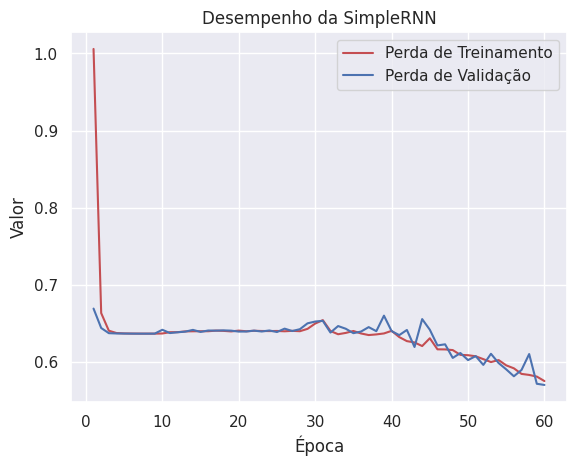

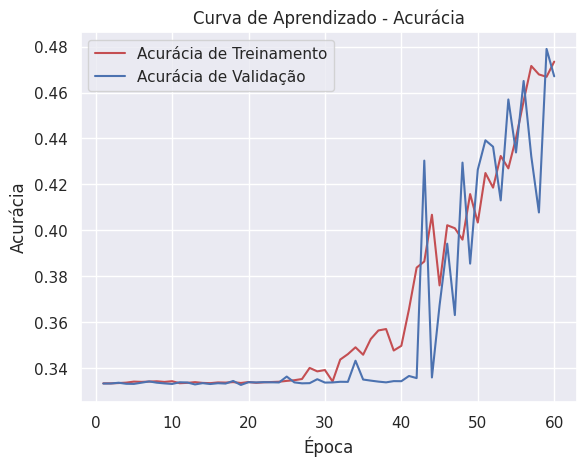

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plotar a curva de aprendizado da perda
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x=range(1, len(loss) + 1), y=loss, color='r', label='Perda de Treinamento')
sns.lineplot(x = range(1, len(val_loss) + 1), y= val_loss, color='b', label='Perda de Validação')

# Configurações adicionais do gráfico
plt.title('Desempenho da SimpleRNN')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.savefig('perda_47.jpeg')
# Exibe o gráfico
plt.show()

#Plotar a curva de aprendizado da acurácia
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x = range(1, len(accuracy) + 1), y = accuracy, color='r', label='Acurácia de Treinamento')
sns.lineplot(x = range(1, len(val_accuracy) + 1), y = val_accuracy, color='b', label='Acurácia de Validação')
# Configurações adicionais do gráfico
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.savefig('acuracia_47.jpeg')
# Exibe o gráfico
plt.show()

141/141 [==============================] - 16s 112ms/step


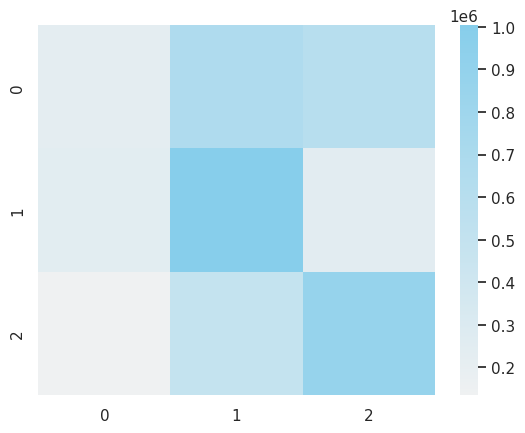

In [ ]:
trainPredict = model.predict(X_test)

output = np.zeros_like(trainPredict)  # Inicializa a matriz de saída com zeros
for i in range(trainPredict.shape[0]):
  for j in range(trainPredict.shape[1]):
    max_value = np.max(trainPredict[i][j])  # Obtém o maior valor da linha
    output[i][j] = (trainPredict[i][j] == max_value).astype(int)  # Atribui 1 ao maior valor e 0 aos demais



labels = np.argmax(output, axis=2)
nique_values, counts = np.unique(labels.flatten(), return_counts=True)
testes = np.argmax(y_test, axis=2)
ytest = testes.flatten()
y_pred = labels.flatten()
cm = confusion_matrix(ytest, y_pred)
cmap = sns.light_palette("skyblue", as_cmap=True)
sns.heatmap(cm, cmap=cmap)
plt.savefig('mapa_calor_47_2.png')
plt.show()

In [ ]:
print(cm)

[[ 225835  668055  605563]
 [ 244790 1003779  250285]
 [ 135527  494423  871743]]


#Seq2Seq

In [ ]:
X,Y = processing_fourier(dados_clear, dados_lte1m, dados_wifi, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=None, train_size=0.7,random_state=42)

model_2 = Sequential()

model_2.add(BatchNormalization(input_shape=(None, 2)))

model_2.add(SimpleRNN(units=128,
                    input_shape=(None, 2),
                    activation="tanh",
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model_2.add(SimpleRNN(units=128,
                    input_shape=(None, 2),
                    activation="relu",
                    kernel_initializer="he_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model_2.add(Dense(units=3,
                activation='softmax'))

opt = Adamax(
        learning_rate=0.003,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model_2.compile(loss='binary_crossentropy',
              optimizer =opt ,
              metrics=['accuracy','AUC', 'Precision', 'Recall'])

history_2 = model_2.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=100,
          batch_size=528)

model_2.summary()

Epoch 1/100
16/16 [==============================] - 42s 2s/step - loss: 0.6477 - accuracy: 0.3333 - auc: 0.5000 - precision: 0.3328 - recall: 0.0119 - val_loss: 0.6395 - val_accuracy: 0.3328 - val_auc: 0.4996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 38s 2s/step - loss: 0.6378 - accuracy: 0.3334 - auc: 0.5003 - precision: 0.6667 - recall: 4.7619e-07 - val_loss: 0.6372 - val_accuracy: 0.3334 - val_auc: 0.5002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 36s 2s/step - loss: 0.6370 - accuracy: 0.3341 - auc: 0.5007 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6371 - val_accuracy: 0.3335 - val_auc: 0.5002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
16/16 [==============================] - 39s 2s/step - loss: 0.6368 - accuracy: 0.3342 - auc: 0.5009 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6368 - val_accuracy: 0.3332

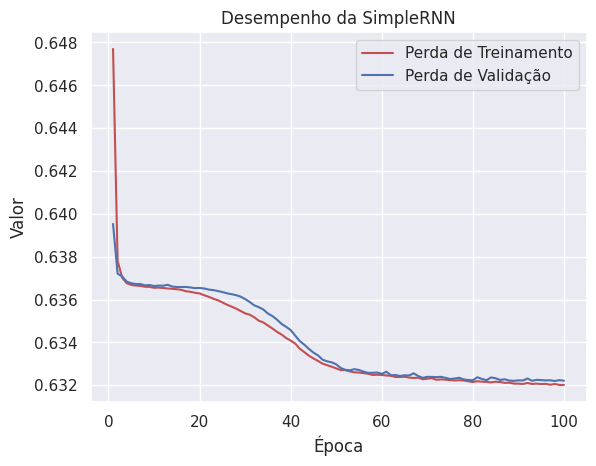

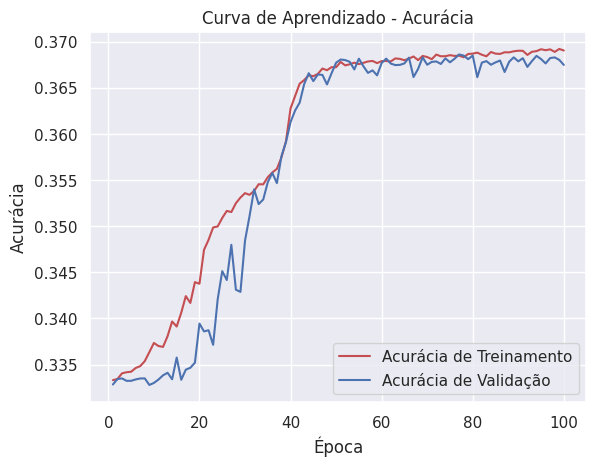

In [ ]:
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
accuracy_2 = history_2.history['accuracy']
val_accuracy_2 = history_2.history['val_accuracy']

# Plotar a curva de aprendizado da perda
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x=range(1, len(loss_2) + 1), y=loss_2, color='r', label='Perda de Treinamento')
sns.lineplot(x = range(1, len(val_loss_2) + 1), y= val_loss_2, color='b', label='Perda de Validação')

# Configurações adicionais do gráfico
plt.title('Desempenho da SimpleRNN')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.savefig('perda_100_epocas_seq2seq.jpeg')
# Exibe o gráfico
plt.show()

#Plotar a curva de aprendizado da acurácia
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x = range(1, len(accuracy_2) + 1), y = accuracy_2, color='r', label='Acurácia de Treinamento')
sns.lineplot(x = range(1, len(val_accuracy_2) + 1), y = val_accuracy_2, color='b', label='Acurácia de Validação')
# Configurações adicionais do gráfico
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.savefig('acuracia_100_epocas_seq2seq.jpeg')
# Exibe o gráfico
plt.show()

141/141 [==============================] - 25s 173ms/step


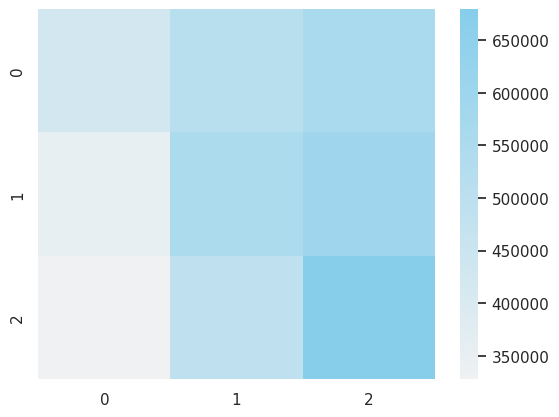

In [ ]:
trainPredict = model_2.predict(X_test)

output = np.zeros_like(trainPredict)  # Inicializa a matriz de saída com zeros
for i in range(trainPredict.shape[0]):
  for j in range(trainPredict.shape[1]):
    max_value = np.max(trainPredict[i][j])  # Obtém o maior valor da linha
    output[i][j] = (trainPredict[i][j] == max_value).astype(int)  # Atribui 1 ao maior valor e 0 aos demais



labels = np.argmax(output, axis=2)
nique_values, counts = np.unique(labels.flatten(), return_counts=True)
testes = np.argmax(y_test, axis=2)
ytest = testes.flatten()
y_pred = labels.flatten()
cm = confusion_matrix(ytest, y_pred)
cmap = sns.light_palette("skyblue", as_cmap=True)
sns.heatmap(cm, cmap=cmap)
plt.savefig('mapa_calor_100_epocas_seq2seq.png')
plt.show()

In [ ]:
X,Y = processing_fourier(dados_c, dados_l, dados_w, 2)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=None, train_size=0.7,random_state=42)
model_2 = Sequential()

model_2.add(BatchNormalization(input_shape=(None, 2)))

model_2.add(SimpleRNN(units=128,
                    input_shape=(None, 2),
                    activation="tanh",
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model_2.add(SimpleRNN(units=128,
                    input_shape=(None, 2),
                    activation="relu",
                    kernel_initializer="he_uniform",
                    recurrent_initializer="orthogonal",
                    return_sequences=True))

model_2.add(Dense(units=3,
                activation='softmax'))

opt = Adamax(
        learning_rate=0.003,
        beta_1=0.9,
        beta_2=0.99,
        epsilon=1e-07)

model_2.compile(loss='binary_crossentropy',
              optimizer =opt ,
              metrics=['accuracy','AUC', 'Precision', 'Recall'])

history_2 = model_2.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=100,
          batch_size=528)

model_2.summary()

Epoch 1/100
16/16 [==============================] - 42s 2s/step - loss: 0.6455 - accuracy: 0.3341 - auc: 0.5005 - precision: 0.3340 - recall: 0.0112 - val_loss: 0.6448 - val_accuracy: 0.3334 - val_auc: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
16/16 [==============================] - 40s 2s/step - loss: 0.6375 - accuracy: 0.3368 - auc: 0.5042 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6371 - val_accuracy: 0.3339 - val_auc: 0.5004 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 37s 2s/step - loss: 0.6366 - accuracy: 0.3445 - auc: 0.5132 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6372 - val_accuracy: 0.3344 - val_auc: 0.5012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
16/16 [==============================] - 36s 2s/step - loss: 0.6361 - accuracy: 0.3583 - auc: 0.5301 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6368 - val_accuracy: 0.

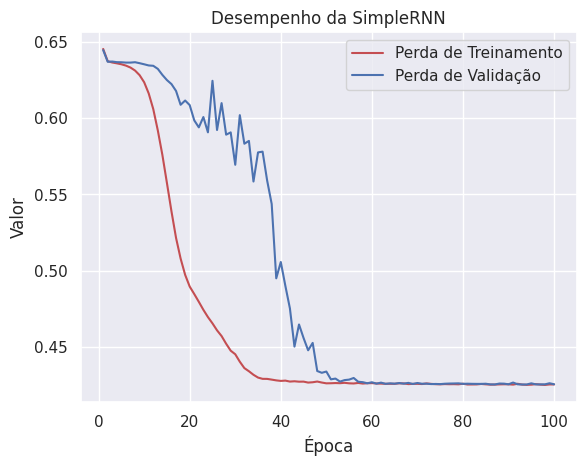

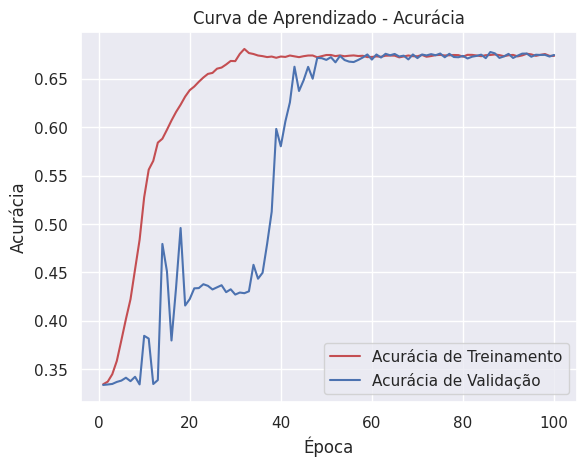

In [ ]:
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']
accuracy_2 = history_2.history['accuracy']
val_accuracy_2 = history_2.history['val_accuracy']

# Plotar a curva de aprendizado da perda
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x=range(1, len(loss_2) + 1), y=loss_2, color='r', label='Perda de Treinamento')
sns.lineplot(x = range(1, len(val_loss_2) + 1), y= val_loss_2, color='b', label='Perda de Validação')

# Configurações adicionais do gráfico
plt.title('Desempenho da SimpleRNN')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.legend()
plt.savefig('perda_67%_seq2seq.jpeg')
# Exibe o gráfico
plt.show()

#Plotar a curva de aprendizado da acurácia
sns.set(style="darkgrid")  # Define o estilo do gráfico
sns.lineplot(x = range(1, len(accuracy_2) + 1), y = accuracy_2, color='r', label='Acurácia de Treinamento')
sns.lineplot(x = range(1, len(val_accuracy_2) + 1), y = val_accuracy_2, color='b', label='Acurácia de Validação')
# Configurações adicionais do gráfico
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.savefig('acuracia_67%_seq2seq.jpeg')
# Exibe o gráfico
plt.show()

141/141 [==============================] - 24s 171ms/step


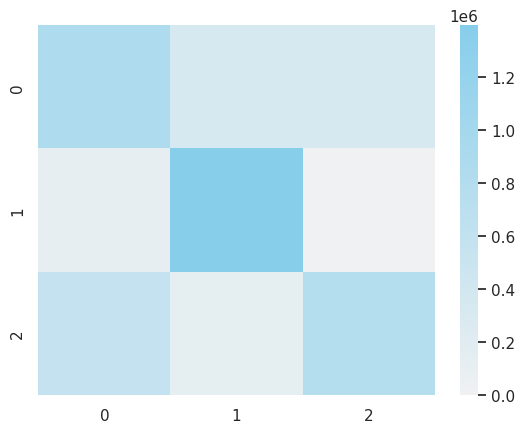

In [ ]:
trainPredict = model_2.predict(X_test)

output = np.zeros_like(trainPredict)  # Inicializa a matriz de saída com zeros
for i in range(trainPredict.shape[0]):
  for j in range(trainPredict.shape[1]):
    max_value = np.max(trainPredict[i][j])  # Obtém o maior valor da linha
    output[i][j] = (trainPredict[i][j] == max_value).astype(int)  # Atribui 1 ao maior valor e 0 aos demais



labels = np.argmax(output, axis=2)
nique_values, counts = np.unique(labels.flatten(), return_counts=True)
testes = np.argmax(y_test, axis=2)
ytest = testes.flatten()
y_pred = labels.flatten()
cm = confusion_matrix(ytest, y_pred)
cmap = sns.light_palette("skyblue", as_cmap=True)
sns.heatmap(cm, cmap=cmap)
plt.savefig('mapa_calor_67%_seq2seq.png')
plt.show()

In [ ]:
print(cm)

[[ 857082  325604  317151]
 [ 106975 1393611       0]
 [ 581799  132904  784874]]
